# Polynomial regression 

The example belows uses a temperature-energy dataset in order to illustrate how to perform a non linear regression.

Workflow:
1. Preparation
    - Extract the dataset from the _power_demand_vs_temperature.csv_ 
    - Explore the dataset and check for missing values
    - Plot the distribution
    - Divide the dataset into train and test 
    - Create an evaluation function
2. First experiment
    - Create a linear model 
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
3. Second experiment
    - Create a polynomial regression model with degree 2
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
4. Third experiment
    - repeat the steps done in the second experiment but with degree 3
5. Third experiment
    - repeat the steps done in the second experiment but with degree 4
6. Compare the evaluation of each model


In [1]:
# Code source: Filippo Orazi 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

random_state = 42 # this will be used to guarantee the repeatability of the experiment

## Dataset preparation

### Load the dataset from a `.csv` file
This cell allows full compatibility between execution in Google Colab and in local


In [3]:
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()


The file must be available in the same directory, or uploaded in the Colab environment in the execution of the previous cell


In [2]:
dataset_url = "power_demand_vs_temperature.csv"
target = "demand"

df = pd.read_csv(dataset_url)
predictor = df.columns[2]

df.sample(10)

,date,demand,temp
528,2016-06-12,1.829542,26.7
1007,2017-10-04,1.793417,26.7
22,2015-01-23,1.892260,1.1
267,2015-09-25,1.852030,25.0
66,2015-03-08,1.620028,7.2
157,2015-06-07,1.936838,28.9
575,2016-07-29,2.429544,28.9
694,2016-11-25,1.530537,7.8
480,2016-04-25,1.630263,26.1
680,2016-11-11,1.530536,13.3


Set the date column as index

In [3]:
df = df.set_index("date")
df.head()

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


### Explore the dataset and check for missing values


In [4]:
df.describe(include="all")

,demand,temp
count,1096.000000,1096.000000
mean,1.831796,16.927737
std,0.329434,10.791581
min,1.316033,-15.000000
25%,1.581654,8.900000
50%,1.731479,18.900000
75%,2.024869,26.100000
max,2.804025,33.900000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 2015-01-01 to 2017-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  1096 non-null   float64
 1   temp    1096 non-null   float64
dtypes: float64(2)
memory usage: 25.7+ KB


In [7]:
print(f"{df.shape[0] - df.dropna().shape[0]} invalid rows")

0 invalid rows


### Create X and y 

In [6]:
X = df.drop(target, axis=1)
y = df[target]
X.shape, y.shape

((1096, 1), (1096,))

### Plot the distribution



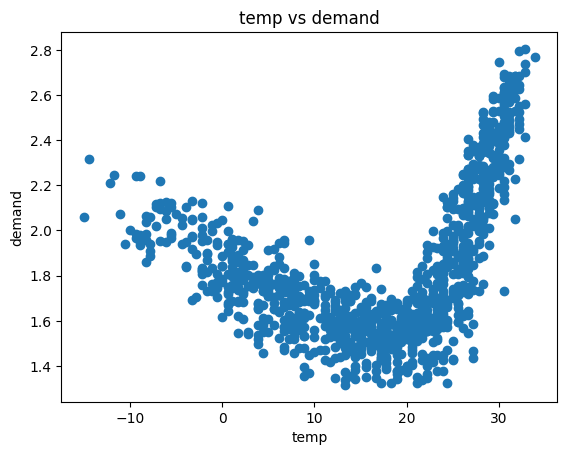

In [7]:
plt.scatter(X, y)
plt.xlabel(predictor)
plt.ylabel(target)
plt.title(f"{predictor} vs {target}")

plt.show()

### Divide the dataset in train and test splits

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((767, 1), (329, 1), (767,), (329,))

### Create an evaluation function to compute, print and return the metrics: rmse r2 f-statistic and p-value

In [10]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def f_test(y_true, y_pred, n_var, n_obs):
    """ Computation of F-statistic and p-value for the regression
    http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
    Requires: np (numpy) and scipy.stats

    Arguments:
    y_true: ground truth
    y_pred: predictions
    n_var: number of predicting variables
    n_obs: number of observations (the length of y_true and y_pred)

    Returns:
    F: F statistics
    p: p-value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var+1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFT = n - 1
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE
    MST = SST / DFT
    F = MSM / MSE
    # f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    p = 1-scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic
    return F, p

def print_eval(X, y, model):
    """ Predicts for X given a fitted model and
        prints prediction quality with respect to y
    Requires f_test (returning F and p-value), mean_squared_error, r2_score

    Arguments:
    X : array-like predicting data
    y : ground truth
    model: predictor fitted model

    Return: MSE, r2_score, F, p-value
    """
    pred = model.predict(X)
    F, p = f_test(y, pred, X.shape[1], X.shape[0])
    print(" Mean squared error: \t{:.5}".format(mean_squared_error(y,pred)))
    print(" r2 score: \t\t{:.5}".format(r2_score(y,pred)))
    print(" f-statistic: \t\t{:.5}".format(F))
    print(" p-value: \t\t{:.5}".format(p))
    return mean_squared_error(pred, y), r2_score(y,pred), F, p

## First experiment
Create a linear model 

Train the model on X_train and y_train 

Evaluate the model on X_test and y_test


In [10]:
lin_estimator = linear_model.LinearRegression().fit(X_train, y_train)

# weight_uni = lin_estimator.coef_[0] # ho utilizzato solo una variabile e quindi ho solo un peso
# intercept = lin_estimator.intercept_
# print(f"intercetta: {intercept}, peso: {weight_uni}")

y_train_pred = lin_estimator.predict(X_train)
y_test_pred = lin_estimator.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE train: {mse_train}, MSE test: {mse_test}")
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R2 train: {r2_train}, R2 test: {r2_test}")

MSE train: 0.09055119878371369, MSE test: 0.10165083485105061
R2 train: 0.11352128714411502, R2 test: 0.16809034828105496


#### Visualize the prediction of the model 

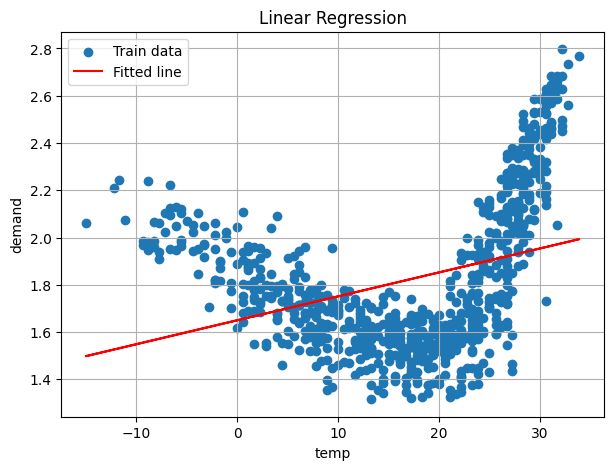

In [11]:
plt.figure(figsize=(7,5))

# scatter dati reali
plt.scatter(X_train, y_train, label="Train data")
# retta di regressione
plt.plot(X_train, y_train_pred, c="red", label="Fitted line")

plt.xlabel(predictor)
plt.ylabel(target)
plt.title("Linear Regression")
plt.legend()
plt.grid(True)

plt.show()

## Second experiment - Polynomial regression
We can clearly see that the linear regression model cannot really approximate the data distribution.

We can now try with a non linear regression model:
1. Use the sklearn fucntion _PolynomialFeature_ to create a new array of features. Set _degree=2_ and _include_bias=False_
2. Train a Linear regression model with the new features
3. Evaluate the model 
4. Visualize the predicted values of the model

#### Polynomial degree = 2

In [19]:
degree = 2
pol_feat = PolynomialFeatures(degree, include_bias=False)
X_train_poly = pol_feat.fit_transform(X_train)
X_test_poly = pol_feat.fit_transform(X_test)

display(X_train)
pd.DataFrame(X_train_poly, columns=["temp", "temp^2"])

,temp
date,
2016-08-14,26.7
2015-11-02,19.4
2015-12-21,10.6
2017-09-25,30.6
2017-11-08,9.4
...,...
2015-11-27,17.8
2016-04-11,17.8
2015-05-02,22.2


,temp,temp^2
0,26.7,712.89
1,19.4,376.36
2,10.6,112.36
3,30.6,936.36
4,9.4,88.36
...,...,...
762,17.8,316.84
763,17.8,316.84
764,22.2,492.84
765,5.0,25.00


In [20]:
lin_estimator = linear_model.LinearRegression().fit(X_train_poly, y_train)

# weight_uni = lin_estimator.coef_[0] # ho utilizzato solo una variabile e quindi ho solo un peso
# intercept = lin_estimator.intercept_
# print(f"intercetta: {intercept}, peso: {weight_uni}")

y_train_pred = lin_estimator.predict(X_train_poly)
y_test_pred = lin_estimator.predict(X_test_poly)

In [21]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE train: {mse_train}, MSE test: {mse_test}")
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R2 train: {r2_train}, R2 test: {r2_test}")

MSE train: 0.03406761338375413, MSE test: 0.03345625006863746
R2 train: 0.6664846576505621, R2 test: 0.7261943063900527


In [39]:
x_values = np.arange(X_train["temp"].min(), X_train["temp"].max()).reshape(-1,1)
display(x_values)
pol_feat.transform(x_values)

array([[-15.],
       [-14.],
       [-13.],
       [-12.],
       [-11.],
       [-10.],
       [ -9.],
       [ -8.],
       [ -7.],
       [ -6.],
       [ -5.],
       [ -4.],
       [ -3.],
       [ -2.],
       [ -1.],
       [  0.],
       [  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 19.],
       [ 20.],
       [ 21.],
       [ 22.],
       [ 23.],
       [ 24.],
       [ 25.],
       [ 26.],
       [ 27.],
       [ 28.],
       [ 29.],
       [ 30.],
       [ 31.],
       [ 32.],
       [ 33.]])

/home/kevin/.local/share/mise/installs/python/3.14.0/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([[-1.500e+01,  2.250e+02],
       [-1.400e+01,  1.960e+02],
       [-1.300e+01,  1.690e+02],
       [-1.200e+01,  1.440e+02],
       [-1.100e+01,  1.210e+02],
       [-1.000e+01,  1.000e+02],
       [-9.000e+00,  8.100e+01],
       [-8.000e+00,  6.400e+01],
       [-7.000e+00,  4.900e+01],
       [-6.000e+00,  3.600e+01],
       [-5.000e+00,  2.500e+01],
       [-4.000e+00,  1.600e+01],
       [-3.000e+00,  9.000e+00],
       [-2.000e+00,  4.000e+00],
       [-1.000e+00,  1.000e+00],
       [ 0.000e+00,  0.000e+00],
       [ 1.000e+00,  1.000e+00],
       [ 2.000e+00,  4.000e+00],
       [ 3.000e+00,  9.000e+00],
       [ 4.000e+00,  1.600e+01],
       [ 5.000e+00,  2.500e+01],
       [ 6.000e+00,  3.600e+01],
       [ 7.000e+00,  4.900e+01],
       [ 8.000e+00,  6.400e+01],
       [ 9.000e+00,  8.100e+01],
       [ 1.000e+01,  1.000e+02],
       [ 1.100e+01,  1.210e+02],
       [ 1.200e+01,  1.440e+02],
       [ 1.300e+01,  1.690e+02],
       [ 1.400e+01,  1.960e+02],
       [ 1

/home/kevin/.local/share/mise/installs/python/3.14.0/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


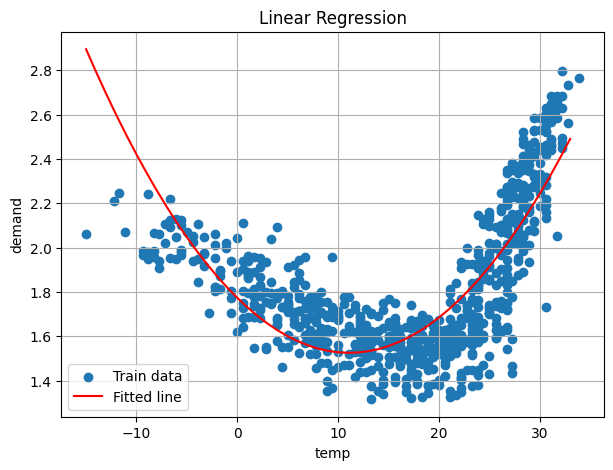

In [40]:
plt.figure(figsize=(7,5))

# scatter dati reali
plt.scatter(X_train, y_train, label="Train data")
# retta di regressione
plt.plot(x_values, lin_estimator.predict(pol_feat.transform(x_values)), c="red", label="Fitted line")

plt.xlabel(predictor)
plt.ylabel(target)
plt.title("Linear Regression")
plt.legend()
plt.grid(True)

plt.show()

## Third experiment

#### Polynomial degree = 3

In [41]:
degree = 3
pol_feat = PolynomialFeatures(degree, include_bias=False)
X_train_poly = pol_feat.fit_transform(X_train)
X_test_poly = pol_feat.fit_transform(X_test)

lin_estimator = linear_model.LinearRegression().fit(X_train_poly, y_train)

# weight_uni = lin_estimator.coef_[0] # ho utilizzato solo una variabile e quindi ho solo un peso
# intercept = lin_estimator.intercept_
# print(f"intercetta: {intercept}, peso: {weight_uni}")

y_train_pred = lin_estimator.predict(X_train_poly)
y_test_pred = lin_estimator.predict(X_test_poly)

In [42]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE train: {mse_train}, MSE test: {mse_test}")
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R2 train: {r2_train}, R2 test: {r2_test}")

MSE train: 0.02230013472446957, MSE test: 0.02174941701778837
R2 train: 0.7816859965125482, R2 test: 0.8220029381670011


/home/kevin/.local/share/mise/installs/python/3.14.0/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


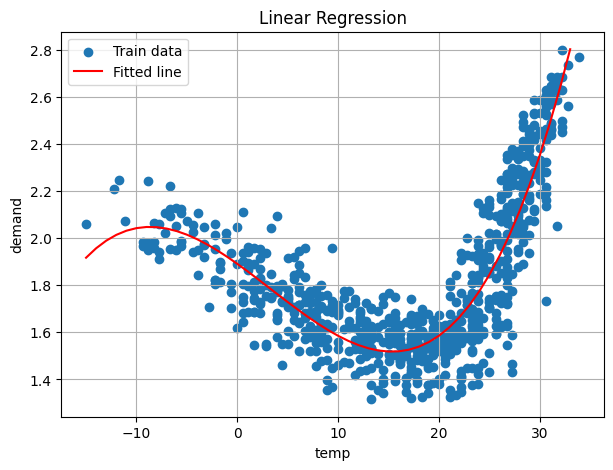

In [45]:
plt.figure(figsize=(7,5))

# scatter dati reali
plt.scatter(X_train, y_train, label="Train data")
# retta di regressione
plt.plot(x_values, lin_estimator.predict(pol_feat.transform(x_values)), c="red", label="Fitted line")

plt.xlabel(predictor)
plt.ylabel(target)
plt.title("Linear Regression")
plt.legend()
plt.grid(True)

plt.show()

## Fourth experiment
### Polynomial degree = 4

In [46]:
degree = 4
pol_feat = PolynomialFeatures(degree, include_bias=False)
X_train_poly = pol_feat.fit_transform(X_train)
X_test_poly = pol_feat.fit_transform(X_test)

lin_estimator = linear_model.LinearRegression().fit(X_train_poly, y_train)

# weight_uni = lin_estimator.coef_[0] # ho utilizzato solo una variabile e quindi ho solo un peso
# intercept = lin_estimator.intercept_
# print(f"intercetta: {intercept}, peso: {weight_uni}")

y_train_pred = lin_estimator.predict(X_train_poly)
y_test_pred = lin_estimator.predict(X_test_poly)

In [47]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE train: {mse_train}, MSE test: {mse_test}")
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R2 train: {r2_train}, R2 test: {r2_test}")

MSE train: 0.02210160440047002, MSE test: 0.021333874235340146
R2 train: 0.7836295699654228, R2 test: 0.8254037371070921


/home/kevin/.local/share/mise/installs/python/3.14.0/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


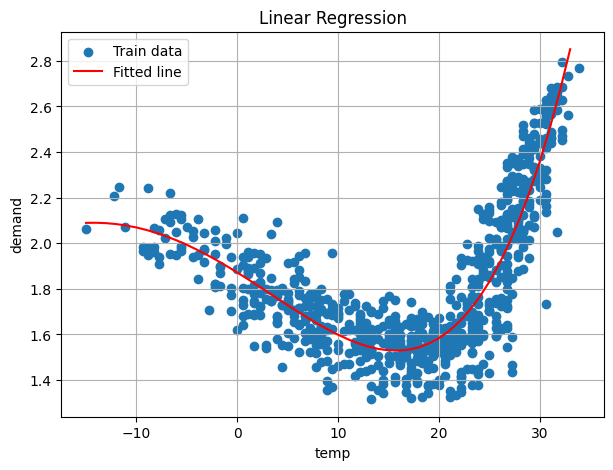

In [49]:
plt.figure(figsize=(7,5))

# scatter dati reali
plt.scatter(X_train, y_train, label="Train data")
# retta di regressione
plt.plot(x_values, lin_estimator.predict(pol_feat.transform(x_values)), c="red", label="Fitted line")

plt.xlabel(predictor)
plt.ylabel(target)
plt.title("Linear Regression")
plt.legend()
plt.grid(True)

plt.show()

## Compare the performance of the four models

,linear,polynomial d = 2,polynomial d = 3,polynomial d = 4
rmse,1.001591e-01,3.345625e-02,2.174942e-02,2.133387e-02
r2,-5.366169e+00,5.756325e-01,7.843318e-01,7.923317e-01
f-statistic,5.327309e+01,3.848865e+02,5.023183e+02,3.900454e+02
p-value,2.219669e-12,1.110223e-16,1.110223e-16,1.110223e-16
